# Исследование объявлений о продаже квартир


Имеются данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет.
Задача - определить рыночную стоимость объектов недвижимости, а для этого нужно установить параметры, влияющие на стоимость. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

Для каждого объекта на продажу доступны два вида данных: первые - вписаны пользователем сервиса, вторые — получены автоматически на основе картографических данных (например, расстояние до центра, аэропорта и тд). 

## Оглавление. 

1.[Открытие данных](#start)   
2.[Предобработка данных](#preprocessing)
* [Обработка пропущенных значений](#null)
* [Замена типа данных](#int)

3.[Добавление синтетических данных](#add)  
4.[Исследовательский анализ](#analysis)
* [Исследование параметров](#parametr)
* [Исследование времени продажи квартир](#time)
* [Преобразование данных - получение среза данных.](#transform) 
* [Выявление факторов, влияющих на стоимость жилья](#search)
* [Анализ 10 населенных пунктов с наибольшим количеством объявлений](#ten)
* [Оценка стоимости жилья в Питере в зависимости от удаленности от центра](#spb)
* [Исследование квартир в центре города](#centr)

5.[Выводы](#conc)


## Открытие данных. Изучение общей информации. <a id="#start"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Выведем общую информацию.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

### Вывод

Итак, всего в данном датафрейме 23699 наблюдений (объявлений). Первое, что бросается в глаза -  в большинстве столбцов мы видим пропуски. Второе - разнообразие типов данных, порой не совсем корректных, например, тип данных столбцов 'floors_total', 'balcony'  и др. Подготовим данные к анализу.

## Предобработка данных <a id="preprocessing"></a>

### Обработка пропущенных значений <a id="null"></a>

Проанализировав столбцы, в которых есть пропуски, можно разделить их на 5 групп:
1. пропуски можно заменить средним значением по столбцу. К таким столбцам относятся - 'ceiling_height', 'living_area', 'kitchen_area', 'days_exposition', 'cityCenters_nearest';
2. пропущенные значения можно заменить на 0 в столбцах, содержащих информацию о количестве балконов. Потому как отсутствующие значения в этом столбце говорят об отсутствии балконов;
3. пропущенные значения можно удалить, например в столбцах 'floors_total', 'locality_name', где количество пропущенных значений менее 1% от всех значений датафрейма;
4. пропущенные значения в столбце 'is_apartment' скорее всего принимают значение False, потому как отсутствующие значения в этом столбце говорят о том, что жилье не является апартаментами;
5. в остальных столбцах с пропущенным значением вместо пропусков проставить пустые значения (нет информации), так как данные относятся к информации, полученной на основе картографических данных.

In [4]:
df.isnull().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

Удалим пропущенные значения в столбцах 'floors_total' и 'locality_name'.

In [5]:
df.dropna(subset= ['floors_total', 'locality_name'], inplace = True)
print(df['floors_total'].isna().sum())#проверка
print(df['locality_name'].isna().sum())#проверка

0
0


Заполним пропуски в столбцах 'ceiling_height', 'living_area', 'kitchen_area', 'days_exposition' и 'cityCenters_nearest'. 

In [6]:
list = ['ceiling_height', 'living_area', 'kitchen_area', 'days_exposition', 'cityCenters_nearest']
for element in list:
    df[element] = df[element].fillna(value= df[element].median())

print(df['ceiling_height'].isna().sum())#проверка
print(df['living_area'].isna().sum())#проверка
print(df['kitchen_area'].isna().sum())#проверка
print(df['days_exposition'].isna().sum())#проверка
print(df['cityCenters_nearest'].isna().sum())#проверка

0
0
0
0
0


In [7]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,2.65,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,2.65,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,2.65,14.0,30.0,9,NaN,...,9.1,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0


Заполним пропуски в столбце с количеством балконов. 

In [8]:
df['balcony'] = df.fillna(value= 0)
df['balcony'].isna().sum()#проверка

0

Заполним пропуски в столбце 'is_apartment'. 

In [9]:
df['is_apartment'] = df.fillna(value= False)
df['is_apartment'].isna().sum()#проверка

0

Наконец, заполним пропуски в самой большой группе столбцов с пропущенными значениями. 

In [10]:
data = ['airports_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']
for element in data:
    df[element] = df[element].fillna(value= '')

df.isna().sum()#проверка

total_images            0
last_price              0
total_area              0
first_day_exposition    0
rooms                   0
ceiling_height          0
floors_total            0
living_area             0
floor                   0
is_apartment            0
studio                  0
open_plan               0
kitchen_area            0
balcony                 0
locality_name           0
airports_nearest        0
cityCenters_nearest     0
parks_around3000        0
parks_nearest           0
ponds_around3000        0
ponds_nearest           0
days_exposition         0
dtype: int64

### Замена типов данных<a id="int"></a>

Изменим тип данных. Как уже было отмечено ранее, не у всех столбцов корретен тип данных. Опять же эти несоответствия можно разделить на несколько видов:
1. данные в столбцах 'floors_total', 'balcony', 'days_exposition' должны быть типа integer, а не float, так как не может 2,5 балкона или 4,1 этажа в доме;
2. данные столбца 'first_day_exposition' должны быть datetime формата;
3. столбец 'is_apartment' должен содержать булевые значения (по аналогии с данными из столбцов 'studio', 'open_plan').

In [11]:
l = ['floors_total', 'balcony', 'days_exposition']
for element in l:
    df[element] = df[element].astype('int') 
df['first_day_exposition'] = pd.to_datetime(df['first_day_exposition'], format= '%Y-%m-%dT%H:%M:%S')
df['is_apartment'] = df['is_apartment'].astype('bool')

In [12]:
df.info()#проверка

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23565 non-null int64
last_price              23565 non-null float64
total_area              23565 non-null float64
first_day_exposition    23565 non-null datetime64[ns]
rooms                   23565 non-null int64
ceiling_height          23565 non-null float64
floors_total            23565 non-null int64
living_area             23565 non-null float64
floor                   23565 non-null int64
is_apartment            23565 non-null bool
studio                  23565 non-null bool
open_plan               23565 non-null bool
kitchen_area            23565 non-null float64
balcony                 23565 non-null int64
locality_name           23565 non-null object
airports_nearest        23565 non-null object
cityCenters_nearest     23565 non-null float64
parks_around3000        23565 non-null object
parks_nearest           23565 non-null object
ponds_around30

Итак, тип данных изменен. Можем двигаться дальше.

##  Добавление синтетических данных <a id="add"></a>

Добавим последовательно несколько столбцов в наши данные, а именно:
1. столбец с информацией о цене за 1 кв.м.
2. день недели, месяц и год публикации объвления;
3. этаж квартиры. Причем с вариантами: первый, поледний, другое;
4. соотношение жилой и общей площади, а также отношение площади кухни к общей.

In [13]:
df['price_metr'] = df['last_price'] / df['total_area']

In [14]:
df['weekday'] = df['first_day_exposition'].dt.weekday
df['month'] = df['first_day_exposition'].dt.month
df['year'] = df['first_day_exposition'].dt.year

In [15]:
df.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.0,8,True,...,16028.0,1,482,2,755,95,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,2.65,11,18.6,1,True,...,18603.0,0,,0,,81,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,2.65,5,34.3,4,True,...,13933.0,1,90,2,574,558,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,2.65,14,30.0,9,False,...,6800.0,2,84,3,234,424,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.0,13,True,...,8098.0,2,112,1,48,121,100000.000000,1,6,2018


Цену за 1 кв.метр нашли, день, месяц и год публикации объявления нашли. Соответствующие столбцы добавлены. Теперь займемся определением этажей и рассчетом соотношений.

In [16]:
def floor_group(floor):
    floors_total = floor['floors_total']
    floor = floor['floor']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    else:
        return 'другое'
df['floor_group_new'] = df.apply(floor_group, axis = 1)

In [17]:
df['living/toal_ratio'] = df['living_area'] / df['total_area']
df['kitchen/toal_ratio'] = df['kitchen_area'] / df['total_area']

In [18]:
df.sample(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,price_metr,weekday,month,year,floor_group_new,living/toal_ratio,kitchen/toal_ratio
13843,6,1850000.0,34.0,2018-03-09,1,2.60,5,27.0,1,True,...,,,57,54411.764706,4,3,2018,первый,0.794118,0.205882
18008,7,12596900.0,91.0,2017-03-21,3,2.65,19,57.0,10,True,...,1,436,218,138427.472527,1,3,2017,другое,0.626374,0.120879
14607,15,5050000.0,64.0,2018-10-16,3,2.50,9,43.0,9,True,...,,,95,78906.250000,1,10,2018,последний,0.671875,0.156250
15613,8,4700000.0,61.0,2015-12-12,3,2.65,9,39.5,7,True,...,0,,200,77049.180328,5,12,2015,другое,0.647541,0.101639
12275,5,8000000.0,73.3,2015-11-30,2,2.80,25,38.3,12,True,...,0,,740,109140.518417,0,11,2015,другое,0.522510,0.206003


## Исследовательский анализ данных <a id="analysis"></a>

### Исследование параметров <a id="parametr"></a>

Изучим площадь, цену, число комнат, высоту потолков и построим гистаграммы для каждого из этих параметров. 

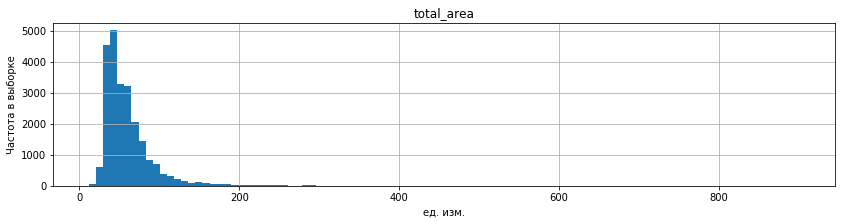

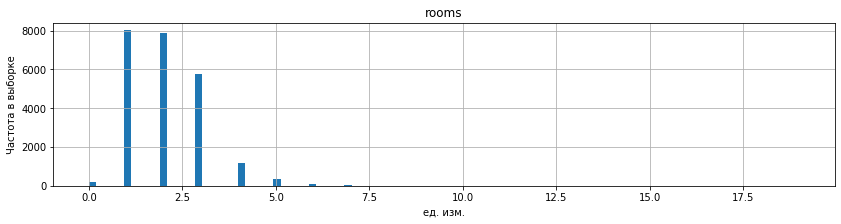

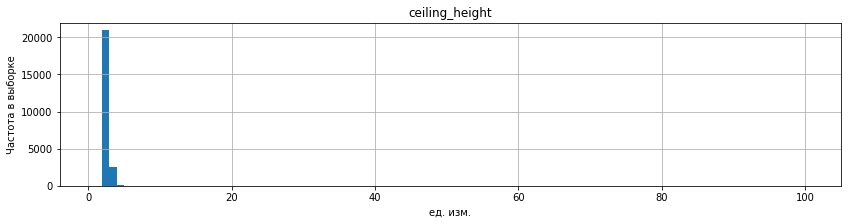

In [19]:
list = ['total_area', 'rooms', 'ceiling_height']
for element in list:
    df.hist(element, bins =100, grid =True, figsize =(14, 3)) 
    plt.xlabel("ед. изм.")
    plt.ylabel("Частота в выборке")
plt.show()

Первая гистограмма имеет высокий пик около значения 40-50, это значит, что площадь квартир из объявлений чаще всего принимают значение 40-50 кв.м. Очень мало значений после 200, наблюдаются отдельные выбросы в районе 400. \
Вторая гистограмма показывает, что квартиры с 1 и 2-мя комнатами встречаются практически одинаково часто (с небольшим перевесом ведут 1-комнатные жилплощади). С достаточной частотой встречаются 3-комнатные квартиры, чуть меньше видим квартир с более 4 комнатами.\
Третья гистограмма демонстрирует нам высокий пик на значении около 2, значит, чаще всего в квартирах потолки около 2м. Нечасто, но все же встречаются жилплощади с потолками выше (около 3м)\
В связи с наличием длинного хвота на диаграмме площади, построим диаграмму размаха для нее и выведем характерные значения данных.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

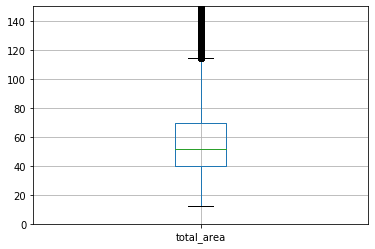

In [20]:
import matplotlib.pyplot as plt
plt.ylim(0, 150)
df.boxplot('total_area')
df['total_area'].describe()

Как видно из диаграммы размаха, значения после примерно 118 кв м, являются выбросом.\
Построим гистограмму для цены за 1 кв.м

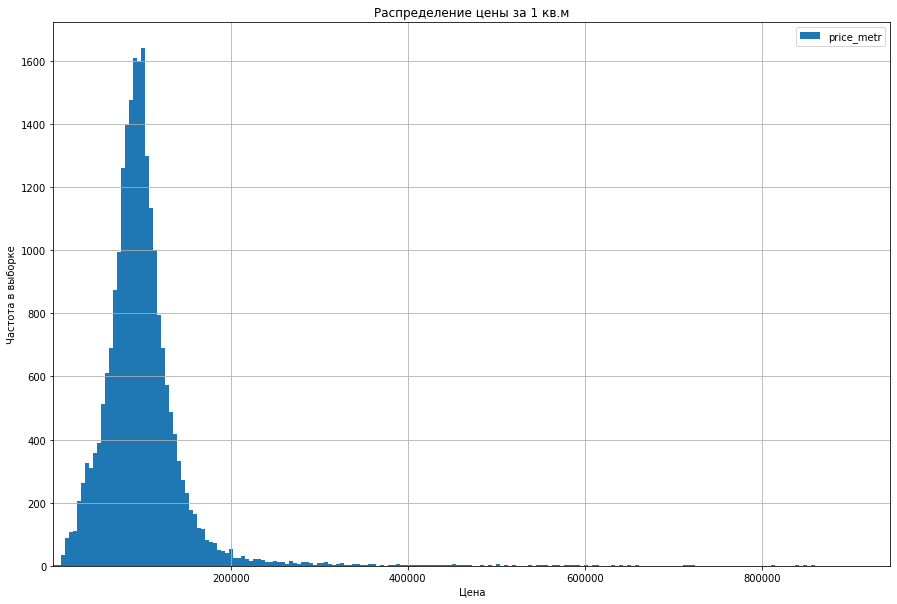

In [21]:
df.plot(kind ='hist', y ='price_metr', figsize=(15, 10), bins =200, range =(0,900000), xlim =True, grid =True,)# legend =True)
plt.title("Распределение цены за 1 кв.м")
plt.xlabel("Цена")
plt.ylabel("Частота в выборке")
plt.show()

Четвертая гистограмма похожа на диаграмму нормального распределения, но с большим хвостом. \
Построим и для этой величины диаграмму разброса.

count    2.356500e+04
mean     9.940584e+04
std      5.038943e+04
min      1.118349e+02
25%      7.656613e+04
50%      9.500000e+04
75%      1.142132e+05
max      1.907500e+06
Name: price_metr, dtype: float64

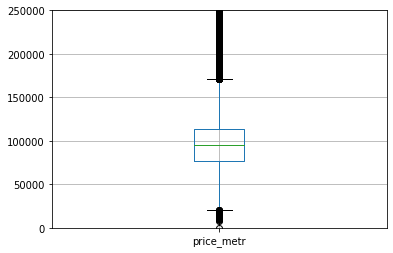

In [22]:
plt.ylim(0, 250000)
df.boxplot('price_metr')
df['price_metr'].describe()

Как показывает диаграмма размаха, все значения вне промежутка 25000-170000 - аномальны. При дальнейшем анализе датасета, эти значения можно не учитывать.\
Рассмотрим также диаграммы размаха для столбцов с числом комнат и высотой потолков, проверим на наличие выбросов в них.

count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

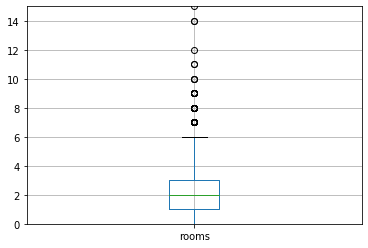

In [23]:
plt.ylim(0, 15)
df.boxplot('rooms')
df['rooms'].describe()

Диаграмма размаха показывает нам, что число комнат больше 6 в квартирах является аномальным. Учтем это в дальнейшем.

count    23565.000000
mean         2.724530
std          0.991026
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max        100.000000
Name: ceiling_height, dtype: float64

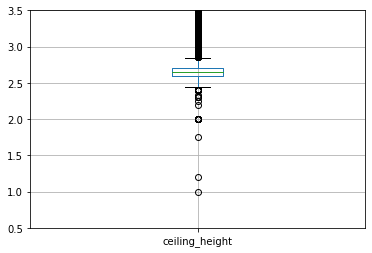

In [24]:
plt.ylim(0.5, 3.5)
df.boxplot('ceiling_height')
df['ceiling_height'].describe()

Диаграмма размаха показывает для высоты потолков указывает нам на то, что в отличие от предыдущих случаев, выбросы у нас наблюдаются и сверху, и снизу. Аномальные значения высоты потолков это значения до нижнего "уса" и после верхнего.

### Исследование времени продажи квартир <a id="time"></a>

Изучим время продажи квартиры, т.е. обратим свое внимание на столбец days_exposition. Построим гистограмму.

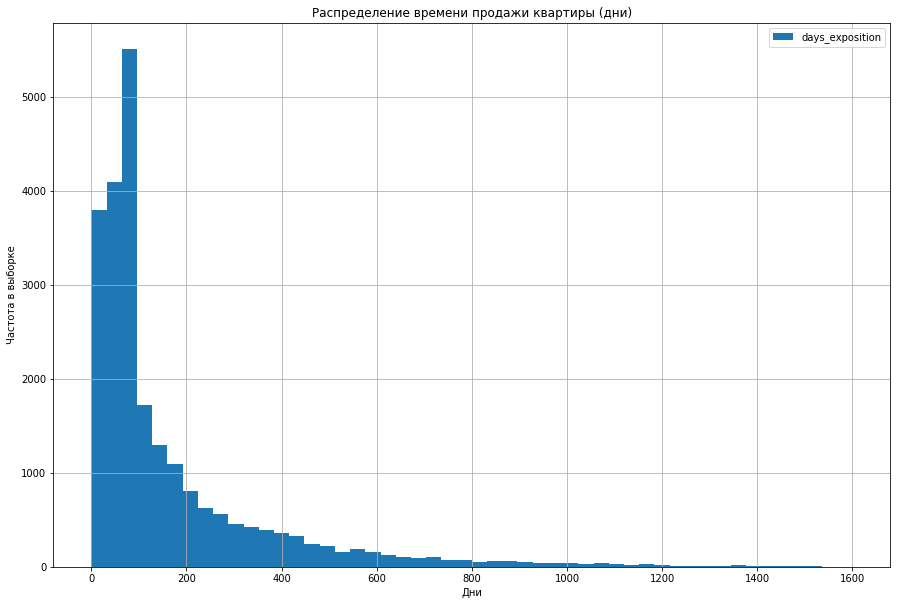

In [25]:
df.plot(kind ='hist', y ='days_exposition', figsize=(15, 10), bins =50, range =(0, 1600), grid =True, legend =True)
plt.title("Распределение времени продажи квартиры (дни)")
plt.xlabel("Дни")
plt.ylabel("Частота в выборке")
plt.show()

count    23565.000000
mean       169.203692
std        206.497729
min          1.000000
25%         45.000000
50%         95.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

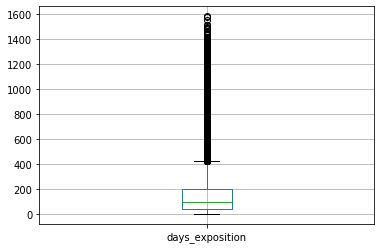

In [26]:
df.boxplot('days_exposition')
df['days_exposition'].describe()

Из построенной диаграммы размаха видно, что нижний  "ус" упирается в 0 - это минимальное значение, верхний "ус" упирается в отметку около 420, все значения выше являются выбросами. Среднее больше медианы больше практически в 2 раза (смотрим на данные, полученные медодом describe()), что говорит о большом хвосте высоких значений, который мы можем наблюдать на гистограмме. Если же проанализировать саму длительность продажи, то в среднем жилплощадь продается на сайте за 160 дней (почти полгода). Большая часть значений лежит в диапазоне до 198 дней. Большая часть значений лежит в диапазоне до 200 дней, а значение первого квартиля 45 дней. Любопытно, что есть продажи, совершенные за 1 день. Выглядит подозрительно. Отсечем быстрые и длинные продажи, использовав 5% и 95% перцентли.

In [27]:
p5_exp = df['days_exposition'].quantile(0.05)
p95_exp = df['days_exposition'].quantile(0.95)
print('Интервал "нормальных значений" по длительности размещения объявления', p5_exp, '-', p95_exp)

Интервал "нормальных значений" по длительности размещения объявления 10.0 - 603.0


Итак, все продажи за менее, чем 10 дней мы отсекли, будем такие продажи считать аномально быстрыми. Затянувшимися продажами будем считать случаи, когда объявление находится в побликации более 603 дней.

### Преобразование данных <a id="transform"></a>

Преобразуем даные, избавившись от выбросов. Приняв во внимание диаграммы разброса для каждого из параметров, которые были построены пунктом ранее, избавимся от выбросов используя перцентили. 

In [28]:
new_df = df.copy()
print('Размер фрейма до очистки:', new_df.shape[0])
p95_area = new_df['total_area'].quantile(0.95)
p5_price = new_df['price_metr'].quantile(0.05)
p95_price = new_df['price_metr'].quantile(0.95)
p95_rooms = new_df['rooms'].quantile(0.95)
p5_height = new_df['ceiling_height'].quantile(0.05)
p95_height = new_df['ceiling_height'].quantile(0.95)

Размер фрейма до очистки: 23565


In [29]:
new_df = new_df.query('total_area <= @p95_area and @p5_price <= price_metr <= @p95_price and rooms <= @p95_rooms and @p5_height <= ceiling_height <= @p95_height')
print('Размер фрейма после очистки по всем параметрам:', new_df.shape[0])

Размер фрейма после очистки по всем параметрам: 19585


После преобразования данных, у нас осталось 15873 наблюдения с нормальными значениями по рассматриваемым параметрам.

### Выявление факторов, влияющих на цену жилья <a id="search"></a>

Изучим влияние различных факторов на цену за жилье. А именно:
1. площадь жилья;
2. число комнат;
3. удаленность от центра;
4. этаж;
5. дата (день, месяц, год) публикации.

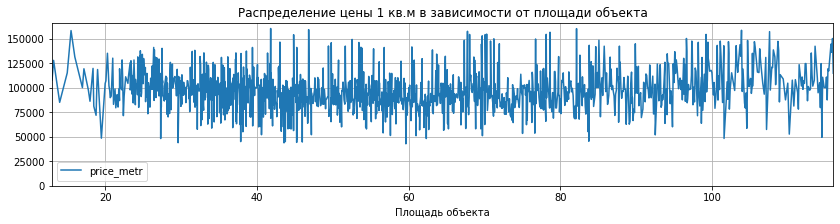

In [30]:
new_df.pivot_table(index ='total_area', values = 'price_metr', aggfunc ='median').plot(ylim =0,  grid=True, figsize=(14, 3))
plt.title("Распределение цены 1 кв.м в зависимости от площади объекта")
plt.xlabel("Площадь объекта")
#plt.ylabel("")
plt.show()

In [31]:
print(new_df['total_area'].corr(new_df['price_metr']))

0.0017526738682578098


Видно, что средняя цена за 1 кв м держится на уровне 100000. Коэффицент корреляции близок к 0, т.е. цена за 1 кв.м никак не зависит от площади жилья. \
Далее рассмотрим зависимость цены 1 кв м от числа комнат.

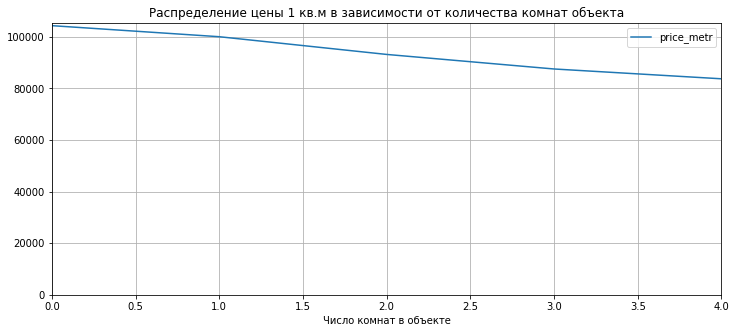

In [32]:
new_df.pivot_table(index ='rooms', values ='price_metr', aggfunc = 'median').plot(ylim =0, grid=True, figsize=(12, 5))
plt.title("Распределение цены 1 кв.м в зависимости от количества комнат объекта")
plt.xlabel("Число комнат в объекте")
plt.show()

Наблюдаем следующую тенденцию - с увеличением числа комнат цена за 1 кв.м уменьшается, что логично. Ведь чем больше комнат, тем больше жилая площадь и меньше цена за кв.м. Выведем для большей наглядности цены за кв.м для всех вариантов чиссла комнат.

In [33]:
new_df.groupby('rooms').agg({'price_metr': 'median'})

,price_metr
rooms,
0,104285.714286
1,100000.000000
2,93137.254902
3,87500.000000
4,83695.652174


In [34]:
new_df['rooms'].corr(new_df['price_metr'])

-0.17745871733237925

Коэффицент корреляции отрицателен, что говорит нам о том, что рост числа комнат ведет к уменьшению цены за кв.м, что и подтверждается графиком выше. \
Перейдем к следующему параметру - посмотрим как на цену влияет удаленность от центра.

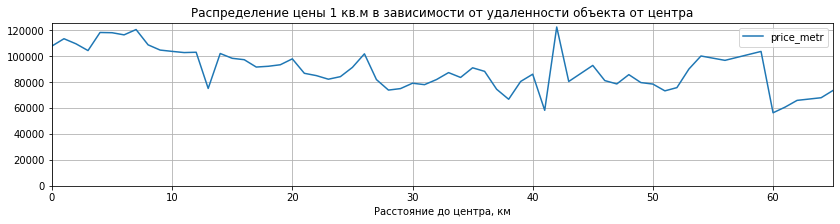

In [35]:
new_df['centr_km'] = new_df['cityCenters_nearest'] // 1000
new_df.pivot_table(index ='centr_km', values ='price_metr', aggfunc = 'median').plot(ylim =0, grid=True, figsize=(14, 3))
plt.title("Распределение цены 1 кв.м в зависимости от удаленности объекта от центра")
plt.xlabel("Расстояние до центра, км")
plt.show()

Наблюдаем следующую тенденцию: по мере удаления от центра цена за 1кв м уменьшается от 150 тыс. до 80 тыс. Однако,  после 40-го км данная тенденция нарушается. Посмотрим на диаграмму размаха.

31.0


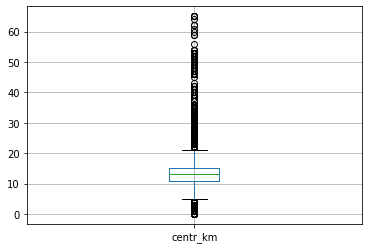

In [36]:
new_df.boxplot('centr_km')
print(new_df['centr_km'].quantile(0.95))

Диаграмма размаха показывает, что значения после 21-го км - аномальны. Нашли значение 95-го перцентиля, для значений больше 31 км, видимо, зависимость цены за 1 кв. м от расстояния до центра не столь однозначна. Получается, что уменьшение цены за 1 кв.м справедливо только до 31 км, а дальше этого значения так однозначно рассуждать нельзя.

In [37]:
new_df['centr_km'].corr(new_df['price_metr'])

-0.25470879867216484

Наблюдаем картину как и с предыдущим параметром - увеличение расстояния до центра ведет к уменьшению стоимости  1 кв.м., что поддтверждается отрицательным коэфф. корреляции. \
Рассмотрим далее влияние этажности на цену.

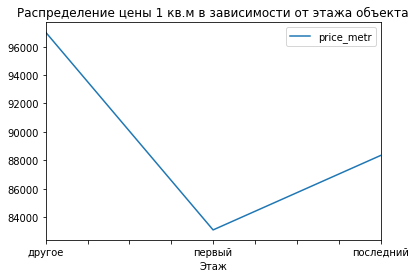

In [38]:
report = new_df.groupby('floor_group_new').agg({'price_metr': 'median'})
report.plot()
plt.title("Распределение цены 1 кв.м в зависимости от этажа объекта")
plt.xlabel("Этаж")
plt.show()

Как видно из графика - дороже всего квартиры на средних этажах, дешевле всего квадратный метр на первом этаже. Видимо, людей отпугивает шум и доступность для злоумышленников, которые возможны, когда живешь на первом этаже. Последние этажи могут отпугивать возможными протечками с крыш или, наоборот, своей недоступностью (особенно при отсутствии лифта).\
Сделаем то же самое и для оценки стоимости в зависимости от дня недели, месяца и года, в которые были вывешены объявления.

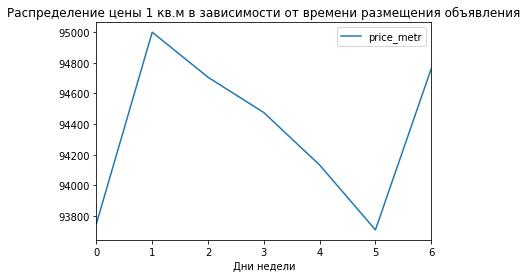

In [39]:
report = new_df.groupby('weekday').agg({'price_metr': 'median'})
report.plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени размещения объявления")
plt.xlabel("Дни недели")
plt.show()

График показывает, что объявления, размещенные по вторникам являются самыми дорогими. Цена за 1 кв м уменьшается со вторника по субботу, в субботу мы наблюдаем ценовой минимум, затем в воскресенье - цена снова вырастает.   

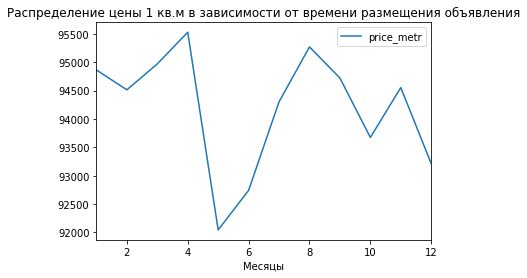

In [40]:
report = new_df.groupby('month').agg({'price_metr': 'median'})
report.plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени размещения объявления")
plt.xlabel("Месяцы")
plt.show()

Наиболее высокая цена 1 кв.м наблюдается в апреле и августе. В мае видим, что цена за кв.м досигает минимума по значению. Возможно, в мае, в предверии летних отпусков люди стали продавать дачи, летние домики, цена которых ниже. Все лето наблюдается рост цен, затм спад с агуста по октябрь. В ноябре вновь скачок цены.  

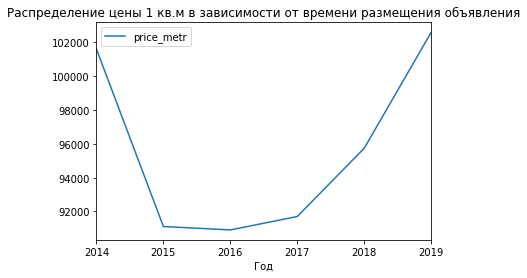

In [41]:
report = new_df.groupby('year').agg({'price_metr': 'median'})
report.plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени размещения объявления")
plt.xlabel("Год")
plt.show()

На графике наблюдаем как за время кризиса (2014-2015 гг) цены на жилье упали и оставались примерно на одном уровне 1,5 года (2015 - 2017 гг), а с 2017 наблюдается уверенный рост на жилье. Любопытно было бы посмотреть данные, включающие в себя и прошедший год:)

### Анализ 10 населенных пунктов с наибольшим кол-вом объявлений <a id ="ten"></a>

Рассмотрим 10 населённых пунктов с наибольшим числом объявлений. Посчитаем среднюю цену квадратного метра в этих населённых пунктах, и выделим среди них населённые пункты с самой высокой и низкой стоимостью жилья.

In [42]:
data = new_df.groupby('locality_name').agg({'first_day_exposition': 'count', 'price_metr': 'mean', 'last_price': ['max', 'min']}).sort_values(by= ('first_day_exposition', 'count'), ascending = False).head(10)
display(data)

first_day_exposition     price_metr  last_price           
                                 count           mean         max        min
locality_name                                                               
Санкт-Петербург                  13055  104898.553380  18500000.0  1190000.0
посёлок Мурино                     516   85733.030887   8500000.0  1730000.0
посёлок Шушары                     433   78589.012200  10990000.0  1500000.0
Всеволожск                         386   67479.052162  10890000.0   965780.0
Пушкин                             330  101368.438160  16912000.0  1990000.0
Колпино                            327   75530.658059  12750000.0  2100000.0
посёлок Парголово                  325   90362.345200   9140000.0  1400000.0
деревня Кудрово                    298   92409.726322  10500000.0  1800000.0
Гатчина                            295   69557.103903  13900000.0  1480000.0
Выборг                             201   59586.482241   8000000.0  1050000.0

Итак, выделим населённые пункты с самой высокой и низкой стоимостью жилья.

In [43]:
data.sort_values(by= ('last_price', 'max'), ascending= False)

first_day_exposition     price_metr  last_price           
                                 count           mean         max        min
locality_name                                                               
Санкт-Петербург                  13055  104898.553380  18500000.0  1190000.0
Пушкин                             330  101368.438160  16912000.0  1990000.0
Гатчина                            295   69557.103903  13900000.0  1480000.0
Колпино                            327   75530.658059  12750000.0  2100000.0
посёлок Шушары                     433   78589.012200  10990000.0  1500000.0
Всеволожск                         386   67479.052162  10890000.0   965780.0
деревня Кудрово                    298   92409.726322  10500000.0  1800000.0
посёлок Парголово                  325   90362.345200   9140000.0  1400000.0
посёлок Мурино                     516   85733.030887   8500000.0  1730000.0
Выборг                             201   59586.482241   8000000.0  1050000.0

In [44]:
data.sort_values(by= ('last_price', 'min'), ascending= True)

first_day_exposition     price_metr  last_price           
                                 count           mean         max        min
locality_name                                                               
Всеволожск                         386   67479.052162  10890000.0   965780.0
Выборг                             201   59586.482241   8000000.0  1050000.0
Санкт-Петербург                  13055  104898.553380  18500000.0  1190000.0
посёлок Парголово                  325   90362.345200   9140000.0  1400000.0
Гатчина                            295   69557.103903  13900000.0  1480000.0
посёлок Шушары                     433   78589.012200  10990000.0  1500000.0
посёлок Мурино                     516   85733.030887   8500000.0  1730000.0
деревня Кудрово                    298   92409.726322  10500000.0  1800000.0
Пушкин                             330  101368.438160  16912000.0  1990000.0
Колпино                            327   75530.658059  12750000.0  2100000.0

Итак, самая высокая стоимость жилья, как и предполагалось - в самом Питере, на втором месте Всеволжск, на третьем - Выборг. \
Рейтинг самой низкой стоимости жилья выглядит следующим образом: 1-е место у Тихвина, 2-е место занимает пгт Дубровка, и 3-е место достается Всеволжску. Т.о. получается, что Всеволжск занимает 2-е место в обоих рейтингах. Видимо, в этом городе есть как обычные панельные многоэтажки, так и частные загородные дома.

### Оценка стоимости жилья в Питере в зависимости от удаленности от центра<a id="spb"></a>

Для начала выделим из нашего датафрейма объяления в пределах Питера.

In [45]:
spb =new_df.query('locality_name == "Санкт-Петербург"')
print('Размер датафрейма после очистки:', spb.shape[0])

Размер датафрейма после очистки: 13055


Теперь построим графики, на которых будет изображена зависимость средней цены за 1 кв.м. от расстояния до центра (красная линия), а также - количество объявлений на каждый км расстояния до центра (черная линия).

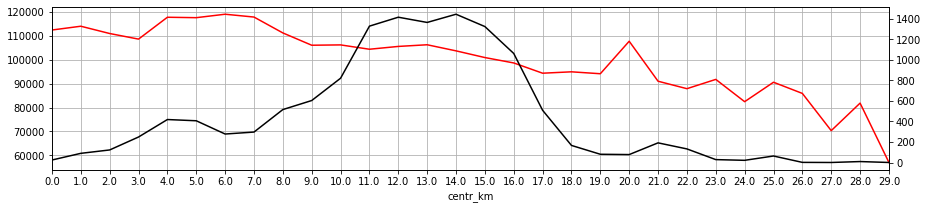

In [46]:
report = spb.groupby('centr_km').agg({'price_metr': 'mean', 'last_price': 'count'})
ax = report['price_metr'].plot(grid =True, figsize = (15, 3), color = 'red')# график средней цены за км
report['last_price'].plot(figsize = (15, 3), ax = ax.twinx(), color = 'black')# график числа объявлений
plt.xticks(report.index.values, report.index.values) 
plt.show()

Красная линия нам показывает среднюю стоимость 1 кв.м на каждом км, а черная - количество объявлений на каждом км расстояния от центра. Видим, что цена с 7-го километра начинает снижаться, в то время как количество объявлений на этом же значении начинет расти. Смею предположить, что в центральную зону входит облать радиусом 7 км от центра города.

### Исследование квартир в центре города <a id="centr"></a>

Выделим сегмент квартир в центре. Проанализируем эту территорию и изучим следующие параметры: площадь, цена, число комнат, высота потолков. Также выделим факторы, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

In [47]:
centr = spb.query('centr_km <= 7')
print('Размер датафрейма после очистки:', centr.shape[0])

Размер датафрейма после очистки: 1888


Проанализируем по данному датасету следующие параметры: площадь, цена, число комнат, высота потолков. 

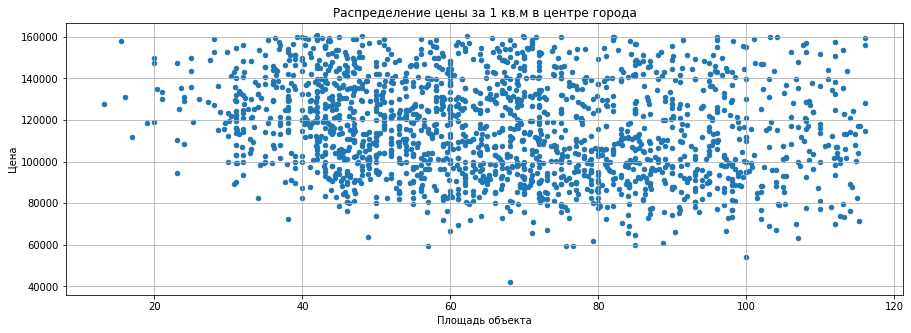

In [48]:
centr.plot(kind='scatter', x = 'total_area', y = 'price_metr', figsize=(15, 5), grid =True)
plt.title("Распределение цены за 1 кв.м в центре города")
plt.xlabel("Площадь объекта")
plt.ylabel("Цена")
plt.show()

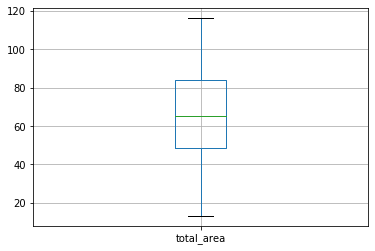

In [49]:
centr.boxplot('total_area')
plt.show()

Итак, в центре чаще всего распространены квартиры с площадью от 40 до 70 (наиболее плотное рассредоточие), чуть меньше квартир площадью 80-100 кв.м, и еще меньше от 100 и больше. Не особо распространены картиры площадью менее 40 кв.м, но таковые все же есть.Как показывает диграмма размаха - аномалий среди значений в данном случае нет.\
Перейдем к следующему параметру - числу комнат.

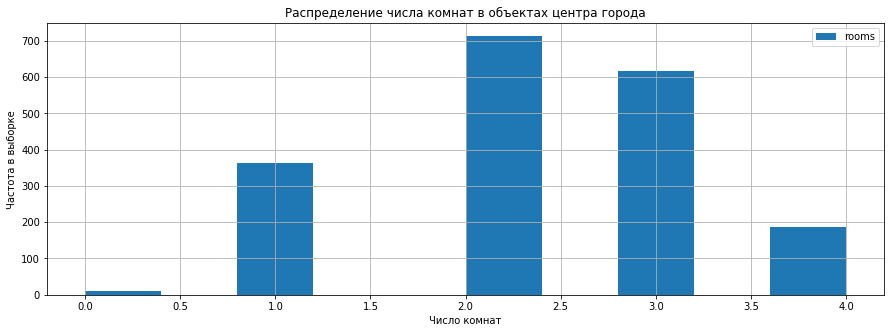

In [50]:
centr.plot(y= 'rooms', kind='hist', figsize=(15, 5), grid =True)
plt.title("Распределение числа комнат в объектах центра города")
plt.xlabel("Число комнат")
plt.ylabel("Частота в выборке")
plt.show()

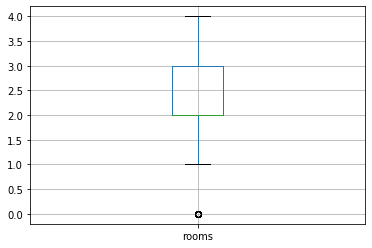

In [51]:
centr.boxplot('rooms')
plt.show()

В центре реже всего встречаются квартиры с 4 комнатами, а чаще всего - двухкомнатные, чуть реже - трехкомнатные. Видимо, в центральном районе планировка квартир в основном именно на 2-3 комнаты. Значение у нуля считаем выбросом.

In [52]:
p5_rooms = centr['rooms'].quantile(0.05)

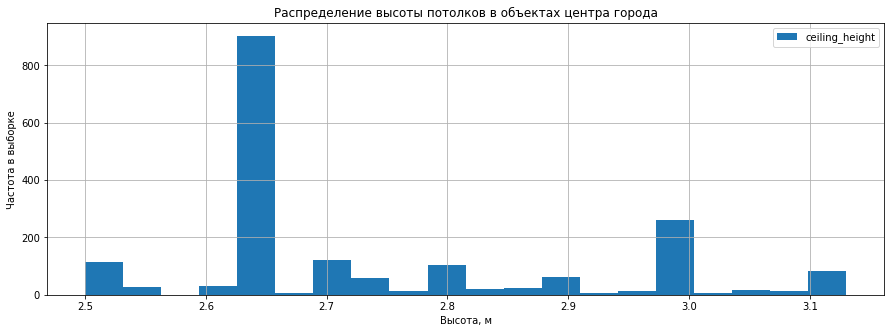

In [53]:
centr.plot(y= 'ceiling_height', kind='hist', bins=20, figsize=(15, 5), grid =True)
plt.title("Распределение высоты потолков в объектах центра города")
plt.xlabel("Высота, м")
plt.ylabel("Частота в выборке")
plt.show()

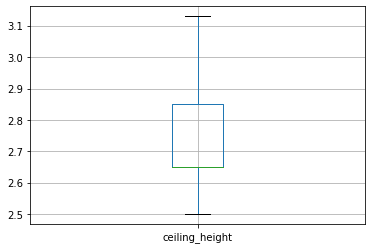

In [54]:
centr.boxplot('ceiling_height')
plt.show()

Как показывают данные, в центре квартиры с высокими потолками от 2.5 м. Но чаще всего в объявлениях фигурирует высота 2.65, реже 3 м, остальные значения - примерно на одном уровне. Как видно из диаграммы размаха, выбросов среди значений по этому критерию у нас нет.

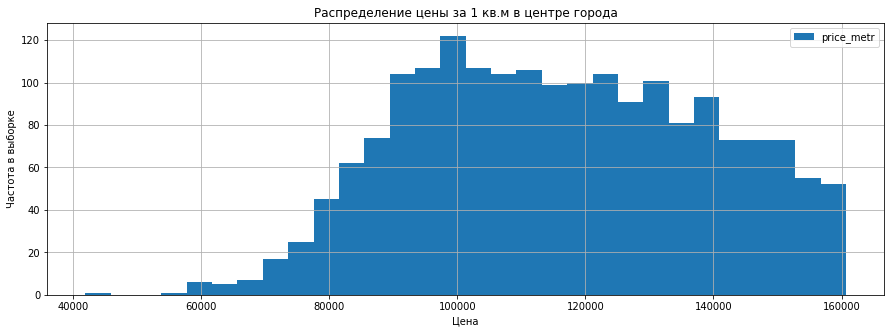

In [55]:
centr.plot(y= 'price_metr', kind='hist', bins=30, figsize=(15, 5), grid =True)
plt.title("Распределение цены за 1 кв.м в центре города")
plt.xlabel("Цена")
plt.ylabel("Частота в выборке")
plt.show()

Похоже на нормальное распределение, но есть какой-то хвост спереди. Проверим данные на наличие аномалий.

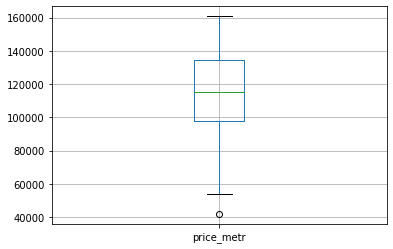

In [56]:
centr.boxplot('price_metr')
plt.show()

Как показывает диаграмма разброса, есть аномалия до нижнего "уса". Вычислим 5 перцентиль.

In [57]:
p5_price = centr['price_metr'].quantile(0.05)

Итак, для центральной части города мы рассмотрели такие параметры как: цена за 1 кв.м, число комнат, высота потолков, а также площадь квартир. В некоторых из них были выявлены аномалии, которые будут отсечены перед дальнейшим анализом квартир в этой части города.

In [58]:
new_centr = centr.query('price_metr >= @p5_price and rooms >= @p5_rooms')
print('Размер фрейма после очистки по всем параметрам:', new_centr.shape[0])

Размер фрейма после очистки по всем параметрам: 1782


Пришло время изучить влияние факторов, которые влияют на стоимость квартиры (число комнат, этаж, удалённость от центра, дата размещения объявления).

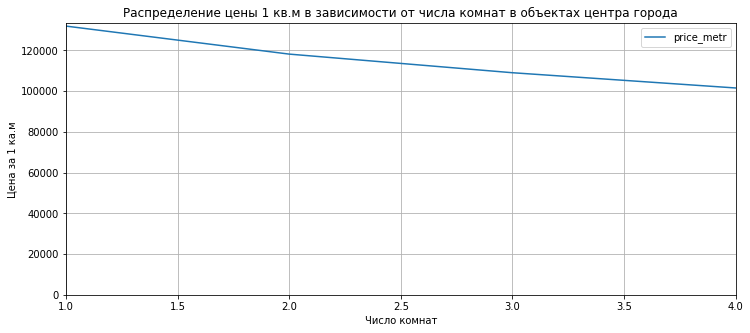

In [59]:
new_centr.pivot_table(index ='rooms', values ='price_metr', aggfunc = 'median').plot(ylim =0, grid=True, figsize=(12, 5))
plt.title("Распределение цены 1 кв.м в зависимости от числа комнат в объектах центра города")
plt.xlabel("Число комнат")
plt.ylabel("Цена за 1 ка.м")
plt.show()

In [60]:
new_centr['rooms'].corr(new_centr['price_metr'])

-0.3391582032402999

Как видно из графика, а также подтверждено коэффициентом корреляции - увеличение числа комнат приводит к уменьшению цены за 1 кв.м. Такая же тенденция наблюдалась при рассмотрении этого параметра для всего города.

Text(0, 0.5, 'Цена за 1 ка.м')

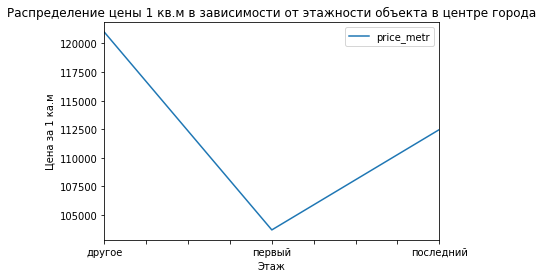

In [61]:
report = new_centr.groupby('floor_group_new').agg({'price_metr': 'median'})
report.plot()
plt.title("Распределение цены 1 кв.м в зависимости от этажности объекта в центре города")
plt.xlabel("Этаж")
plt.ylabel("Цена за 1 ка.м")

Снова видим похожую картину - в центре первые этажи не пользуются спросом, намного востребованнее (соответственно, и дороже) этажи посередине, ну или хотя бы последний. Различие в графиках по цене за 1 кв.м. - цена за 1 кв.м вне центра  на среднем этаже примерно на том же уровне, что и цена за 1 кв.м в центре на последнем.

Text(0, 0.5, 'Цена за 1 ка.м')

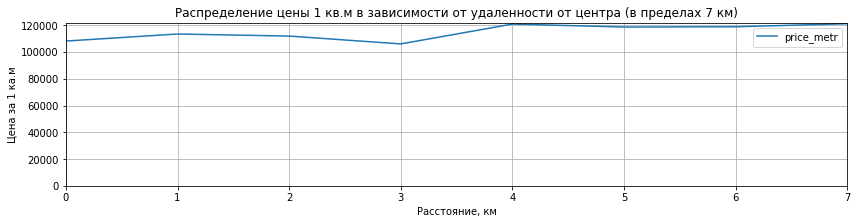

In [62]:
new_centr.pivot_table(index ='centr_km', values ='price_metr', aggfunc = 'median')\
                        .plot(xlim=0, ylim =0, grid=True, figsize=(14, 3))
plt.title("Распределение цены 1 кв.м в зависимости от удаленности от центра (в пределах 7 км)")
plt.xlabel("Расстояние, км")
plt.ylabel("Цена за 1 ка.м")

Видим, что цена до 0 до 3 км держится на уровне 110 тыс. за 1 кв.м, однако с 3-го километра она начинает расти и с 4-го по 7-й км, цена за кв.м. составляет уже 120 тыс. Скорее всего, в центре (именно в радиусе 3 км) много туристов, что сказывается на цене жилплощади. 

In [63]:
new_centr['centr_km'].corr(new_centr['price_metr'])

0.10805546659826475

Коэфф. корреляции положительный, а это значит, что по мере удаленности от центра цена за жилье возрастает. В отличие от остальной части города.\
Изучим теперь влияние времени размещения объявления на цену.

Text(0, 0.5, 'Цена за 1 ка.м')

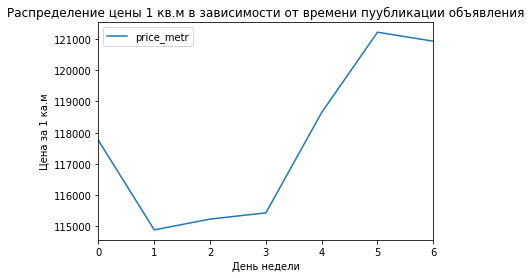

In [64]:
new_centr.groupby('weekday').agg({'price_metr': 'median'}).plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени пуубликации объявления")
plt.xlabel("День недели")
plt.ylabel("Цена за 1 ка.м")

В отличие от ситуации со всем городом, в центре наблюдается 2 минимума по значению цены за кв.м - во вторник и четверг, в то время как во всем городе по вторникам наблюдалась самая высокая цена. В центре же цена достигает макимума в субботу и воскресенье держится примерно на том же уровне.

Text(0, 0.5, 'Цена за 1 ка.м')

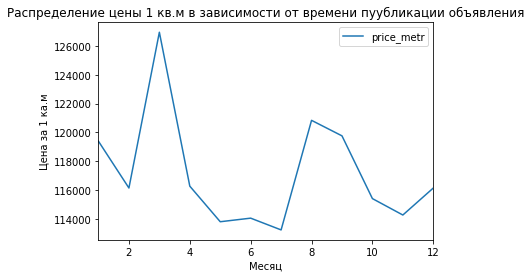

In [65]:
new_centr.groupby('month').agg({'price_metr': 'median'}).plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени пуубликации объявления")
plt.xlabel("Месяц")
plt.ylabel("Цена за 1 ка.м")

Изменение цены по месяцам в центре выглядит динамичнее. Май также как и во всем городе характеризуется спадом цены на жилье. В отличие от всего города, в центре спад цен наблюдается в феврале, июле и ноябре. Самое высокое значение наблюдаем в марте, не такой значительный, но все же росто цен наблюдается и в августе, а в большей чати города - в апреле. Во всем городе с мая по август был плавный рост цены, как видим в центре - цены то росли, то падали.

Text(0, 0.5, 'Цена за 1 ка.м')

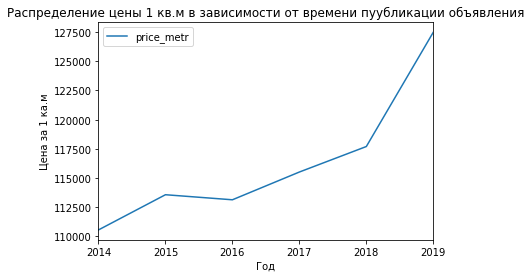

In [66]:
new_centr.groupby('year').agg({'price_metr': 'median'}).plot()
plt.title("Распределение цены 1 кв.м в зависимости от времени пуубликации объявления")
plt.xlabel("Год")
plt.ylabel("Цена за 1 ка.м")

В отличие от всего остального города в центре постоянный рост цен на жилье, стоит отметить, что если в период с 2015 по 2017 гг в городе цены за кв. м. держались примерно на одном уровне, то в центре за аналогичный период цены все таки росли. 

### Общий вывод

Проведен анализ архива объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет с предыдущей предобработкой данных.\
Выявлено, что на цену жилья, как в центре, так и для всего остального города однаково влияют следующие факторы:
1. этаж - люди во всем городе предпочитают средние этажи крайним, соответственно, на крайних этажах цена за 1 кв.м. ниже, чем на серединных;
2. число комнат, чем больше комнат в квартире, тем ниже цена за 1 кв.м.\
Площадь жилья не влияет на стоимость квадратного метра.\
Если просматривать объявления о продаже квартир по датам (месяц и день), то в случае месячных данных - некая схожесть есть (минимальное значение за 1 кв.м в мае), но различий вссе же больше. Если анализировать объявления во всем городе и центре по дням - общего нет ничего. Все таки продажа/приобретение жилья это серьезный вопрос на более широкую переспективу, поэтому надо полагаться на более долгий срок, нежели день или месяц - полгода/год. Поэтому я бы ориентировалась на годовые показатели. Для центра и остальной части города они отличаются. \
Как и отличается динамика цен в зависимости от уаленности от центра. Самые дорогие квартиры находятся в центральной зоне в диапазоне 4-7 км от центра, справа от этого промежутка (т.е. в нецентральной части города) цены за кв.метр падают, в диапазоне 0-3 км -цены немного ниже, но держатся на одном уровне.